In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random
from PIL import Image

Here, I have taken the downloaded datasets. One can try other datasets for this model. That's why, I created a class
of k-means algorithm to generalize for external cases also. For trying other pictures, just replace any of the following image_path with the target image_path, and rest should work fine, I think

In [2]:
# centroids = [(-5, -5), (5, 5)]
# cluster_std = [1, 1]
# X, y = make_blobs(n_samples=100, cluster_std=cluster_std, centers=centroids, n_features=2, random_state=2)
image_path1 = r'D:\drive-download-20240511T193904Z-001\1.png'
image_path2 = r'D:\drive-download-20240511T193904Z-001\2.png'
image_path3 = r'D:\drive-download-20240511T193904Z-001\3.png'
image_path4 = r'D:\drive-download-20240511T193904Z-001\4.png'

# img = []
img1 = Image.open(image_path1)
img2 = Image.open(image_path2)
img3 = Image.open(image_path3)
img4 = Image.open(image_path4)

# Convert to greyscale
image_gray1 = img1.convert("L")         
image_gray2 = img2.convert("L")
image_gray3 = img3.convert("L")
image_gray4 = img4.convert("L")

In [3]:
def model(img):
    
    # To convert the pixels of the images into a 2D array
    image_gray = img.convert("L")
    
    image_array = np.array(image_gray)
    
    return image_array

In [4]:
pxls = model(img1)
pxls.shape

(64, 64)

In [5]:
X = []
for i in range(64):
    for j in range(64):
        if pxls[i][j] != 0:
            X.append([i, j])
        
X = np.array(X)
X.shape

## Why converting all to array, convert them who have one as their y value....

(129, 2)

### Steps for k-means clustering ->
    1. decide clusters
    2. select random centroids
    3. assign clusters
    4. move centroids
    5. check finish

In [16]:
class KMeans:
    def __init__(self, n_clusters, max_iters):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.centroids = None
        
    def fit_predict(self, X):
        random_index = random.sample(range(0, X.shape[0]), self.n_clusters)
        ## The function random.sample takes a population and an integer as arguments to return 
        ## the given integer number of random values.
        
        self.centroids = X[random_index]
        ## We will then store the random_indices in the centroids.
        
        ## Now, the first two steps are done and we are left with last three steps. 
        
        for i in range(self.max_iters):
            ## Basically, we have to do 3 steps in loop.
            ## Assign cluster, move centroids, and if centroids have reached at the desired place, 
            ## we have to break.
            
            # assign cluster
            cluster_group = self.assign_clusters(X)
            old_centroids = self.centroids
            
            # move centroids
            self.centroids = self.move_centroids(X, cluster_group)
            
            # check finish.
            if (old_centroids == self.centroids).all():
                break
                
        return cluster_group, self.centroids
            
    def assign_clusters(self, X):
        cluster_group = []
        distances = []
        ## We will pick every point, check their distance from the initialized centroids, and cluster
        ## each point according to their distance from the initialized centroids.
        
        ## We will put each point in the cluster of that centroid among all the chosen centroids, 
        ## from whom the distance of that point is the minimum.
        for row in X:
            for centroid in self.centroids:
                distances.append(np.sqrt(np.dot((row - centroid), (row - centroid))))
                ## Basically the above function is calculating the distance between each point 
                ## in the X and those in the centroids.
            min_index = min(distances)
            index_pos = distances.index(min_index)
            cluster_group.append(index_pos)
            distances.clear()
            ## Here, this clearing is necessary, because each time, we are getting different 
            ## array of distances. We could have also initialized the distances array inside the first
            ## loop.
            
            
            ## Suppose, we have three clusters, and so we assigned 3 centroids.
            ## distances will contain the distances of each point from all the three centroids
            ## Suppose the centroids are like 0, 1, 2.
            ## So, distances would also be dist0, dist1, dist2.
            ## Then, suppose dist1 is minimum, then the index_pos would become 1.
            ## Thus, the cluster group would be appended by 1. 
            ## So, cluster_group is an array containing 0 or 1 or 2 in this case.
        
        return np.array(cluster_group)
    
        
    def move_centroids(self, X, cluster_group):
        
        new_centroids = []
        
        clusterTypes = np.unique(cluster_group)
        ## Suppose the cluster_group has type 0, 1, 2.
        ## clusterTypes would contain 0, 1 and 2 only.
        
        for types in clusterTypes:
            new_centroids.append(X[cluster_group == types].mean(axis = 0))
            ## This is one of the best loop updatations I have ever gone through.
            ## Here, every point of cluster_group checks types in clusterTypes and if it matches 
            ## with a particular type, that particular type is appended into new_centroids.
        return np.array(new_centroids)

Now, we need to calculate the distances between the centroids of each clusters..

In [17]:
def ElbowMethod(data, max_clusters):
    # We have to choose one by one points with their centroids assigned correctly.
    # Then we have to calculate variances for each of the points selected.
    varArr = []
    slope = []
    for i in range(1, max_clusters+1):
        km = KMeans(i, 2000)
        ## Here, each time we are instantiating the class of KMeans with i number of clusters.
        ## Here, I have increased the number of iterations to increase the accuracy of the model.
        clusters, centroids = km.fit_predict(data)
        ## Now, we have iterate over each cluster points and measure their square of distances and add them
        ## to get the variance for each k.
        var = 0
        ## On calling km.assign_clusters, we will get clusters assigned the values of 0, 1, ......, i values.
        l = clusters.shape[0]
        for j in range(i):
            ## for each clusters,
            for k in range(l):
                if clusters[k] == j:
                    var += np.dot(data[k] - centroids[j], data[k] - centroids[j])
                    
        varArr.append(var)

    size = len(varArr)
    for i in range(size - 1):
        slope.append((varArr[i+1] - varArr[i]))
        
    ## Let's try to get the value k using the slopes as if the left slope is about 10 times that of the right, 
    ## let it be the k...
    k = 1
    for i in range(max_clusters - 3):
        if (abs(slope[i]) >= abs(slope[i+1])*10 and abs(slope[i]) >= abs(slope[i+2])*10):
            k = i+2
            break
    return varArr, slope, k

In [18]:
varArr, slope, k = ElbowMethod(X, 10)
print(slope)
k

## Sometimes, it is throwing error. If it throws error at any point, then please re run from the cell, containing 
## the KMeans class, and everything will be fine. On running it repetitively for different images, error is being
## thrown with a message of broadcasting error.

[-32408.51855919348, -310.52331626940213, -14112.168795248266, -210.29834368530237, -211.9645720945714, 200.3370548449425, -722.9605560644247, -94.48355968506826, -95.2083071898868]


4

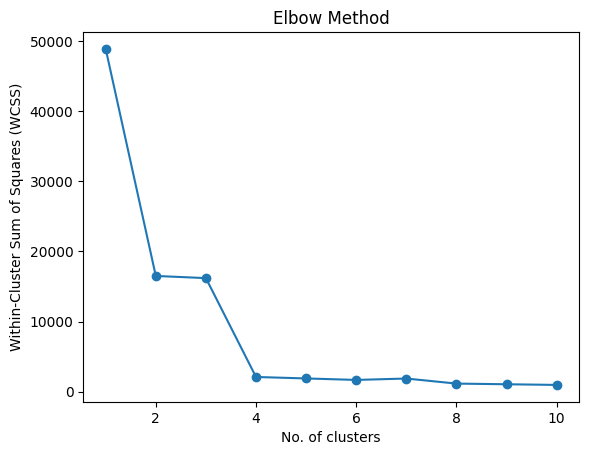

In [19]:
plt.plot(range(1, 11), varArr, marker = 'o')
plt.xlabel('No. of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()

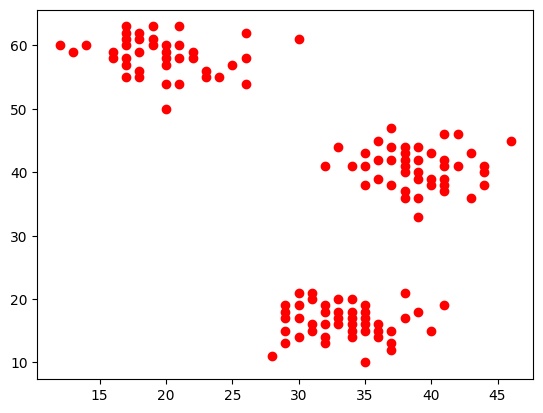

In [20]:
kmeans = KMeans(k, 1000)
y_means, centroids = kmeans.fit_predict(X)
clusters = kmeans.assign_clusters(X)
# plt.scatter(X[y_means == 0, 0], X[y_means == 0, 1], color = 'red')
# plt.scatter(X[y_means == 1, 0], X[y_means == 1, 1], color = 'blue')
# plt.scatter(X[y_means == 2, 0], X[y_means == 2, 1], color = 'green')

for i in range(k):
    plt.scatter(X[y_means == i, 0], X[y_means == i, 1], color = "#FF0000")
plt.show()
# y_means

In [21]:
y_means.shape

(129,)

In [22]:
clusters.shape[0]

129

In [23]:
centroids

array([[33.43478261, 16.45652174],
       [39.95238095, 38.28571429],
       [19.7       , 58.425     ],
       [37.95454545, 43.22727273]])

In [24]:
distances = []
for i in range(0, k):
    distances.append(np.sqrt(np.dot(centroids[i] - centroids[i - 1], centroids[i] - centroids[i - 1])))

print('Distance between the cities is in the order ((k-1)th, 1st), (1st, second)... is: ')
distances

Distance between the cities is in the order ((k-1)th, 1st), (1st, second)... is: 


[27.149610764278847, 22.78141205907661, 28.561333360366692, 23.752880751779657]

In [25]:
print('Distances Table:')
for i in range(k - 1):
    print(f'Distance between {i+1} and {i+2} is {distances[i + 1]}')
print(f'Distance between 1 and {k} is {distances[0]}')

Distances Table:
Distance between 1 and 2 is 22.78141205907661
Distance between 2 and 3 is 28.561333360366692
Distance between 3 and 4 is 23.752880751779657
Distance between 1 and 4 is 27.149610764278847


## THANK YOU